In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np

import os

from matplotlib.gridspec import GridSpec

In [108]:
def unflatten_shots(flat_shots,mask):
    num_shots = flat_shots.shape[0]
    shape = mask.shape
    flat_mask = mask.reshape(shape[0]*shape[1]
                            )
    shots = np.zeros( (num_shots,shape[0]*shape[1]), dtype = flat_shots.dtype)
    shots[:, flat_mask ] = flat_shots
    
    return shots.reshape( (num_shots,shape[0],shape[1]))

def norm_w_mask(x,mask, threshold):
    x_out = np.zeros_like(x, dtype=np.float64)


    k=np.median(x)
    mu = np.std(x)
    this_mask = (np.abs(x - k)<mu*threshold)*mask
    x_out = x/(x[this_mask]).mean()
    
    return x_out, this_mask

def diff_mask(x,norm_ref,mask, ref_mask, threshold):
    norm_x,x_mask = norm_w_mask(x,mask, threshold = threshold)
    
    return (norm_x-norm_ref)*ref_mask*x_mask
   
def diff_all_shots(images,mask,threshold):
    diffs = np.zeros_like(images, dtype=np.float64)
    mean_img = images.mean(0)
    mean_img,mm = norm_w_mask(mean_img,mask, threshold = threshold)
    
    for ii in range(diffs.shape[0]):
        diffs[ii]=diff_mask(images[ii],mean_img,mask,
                            mm,threshold=threshold)
    return diffs

In [192]:
mask=np.load('/reg/d/psdm/cxi/cxilr6716/results/masks/basic_psana_mask.npy')
polar_correct = np.load('/reg/d/psdm/cxi/cxilr6716/scratch/derm/polarization_-400encode.npy')
center=np.load('/reg/d/psdm/cxi/cxilr6716/scratch/derm/center_-400encoder.npy')

In [167]:
file_dir = '/reg/d/psdm/cxi/cxilr6716/scratch/flatfield_calibration/calibrated_shots/'
run=109
f=h5py.File(os.path.join(file_dir,'run%d_shots_cali.h5'%run), 'r')
print f.keys()

cali_shots10=f['cali_single_shots_10'].value/polar_correct[None,:,:]


[u'cali_single_shots_10', u'cali_single_shots_15', u'cali_single_shots_20', u'cali_single_shots_5']


In [168]:
file_dir = '/reg/d/psdm/cxi/cxilr6716/scratch/flatfield_calibration/flat_det_imgs/'
f_imgs=h5py.File(os.path.join(file_dir,'fullImgs_run%d.h5'%run), 'r')
single_shots = f_imgs['flat_img'][:300]
single_shots_int = single_shots.mean(-1)
selection_mask = (single_shots_int>1.3)*(single_shots_int<95.7)
single_shots=single_shots[selection_mask]
single_shots=unflatten_shots( single_shots, mask)/polar_correct[None,:,:]

In [169]:
mean_single_shot=single_shots.mean(0)
mean_cali10 = cali_shots10.mean(0)

In [241]:
def range_mask(img,min,max):
    return (img>min)*(img<max)
def donut_mask(mask,rmin,rmax):
    xx,yy=np.meshgrid(range(mask.shape[1]), range(mask.shape[0]))
    rr = np.sqrt((xx-center[0])**2+(yy-center[1])**2)
    return (rr>rmin)*(rr<rmax)*mask


def draw_circle(ax, radius, center):
    circle1=plt.Circle(center,radius,color='w',
                       linewidth=3, fill=False,
                      linestyle='--',alpha=0.5)
    ax.add_artist(circle1)

In [240]:
xx,yy=np.meshgrid(range(mask.shape[1]), range(mask.shape[0]))
rr = np.sqrt((xx-center[0])**2+(yy-center[1])**2)
(rr>rmin)*(rr<rmax)
center
plt.imshow(rr,aspect=1)

NameError: name 'rmin' is not defined

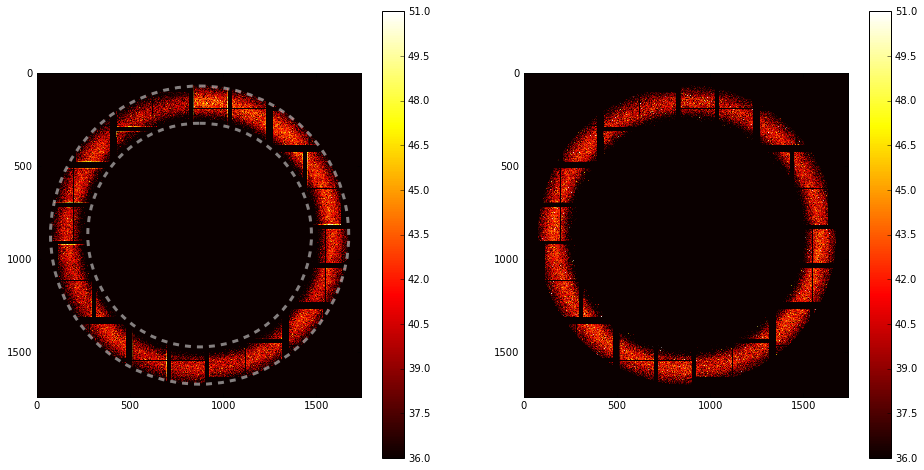

In [264]:
plt.figure(figsize=[16,8])
gs = GridSpec(1,2)
x=36
y=100
# img=range_mask(mean_single_shot,x,y)
img = donut_mask(mask,600,800)
ax=plt.subplot(gs[0,0] )

plt.imshow(mean_single_shot*img,aspect=1,
          cmap='hot',vmin=x,vmax=x+15)
draw_circle(ax,600,center)
draw_circle(ax,800,center)

plt.colorbar()


plt.subplot(gs[0,1])
# img=range_mask(mean_cali10,x,y)
img = donut_mask(mask,600,800)
plt.imshow(img*mean_cali10,aspect=1,
          cmap='hot',vmin=x,vmax=x+15)
plt.colorbar()

In [239]:
mask.shape
rr.shape
xx.shape

(1742, 1738)

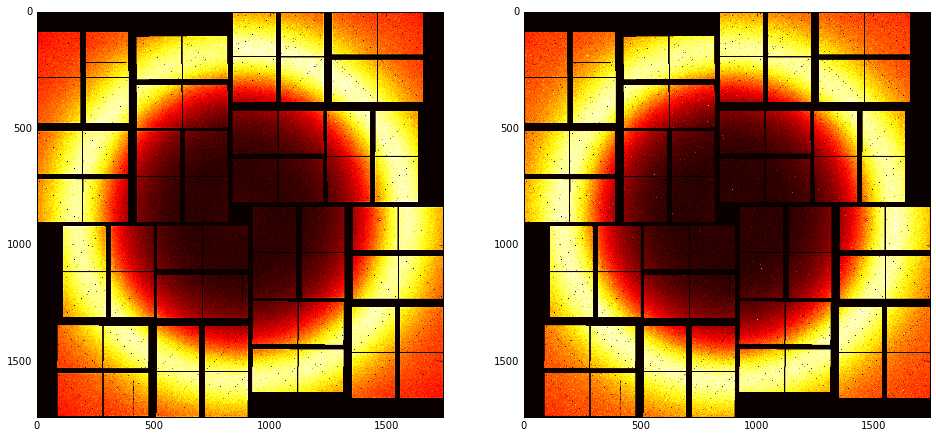

In [174]:
plt.figure(figsize=[16,8])
gs = GridSpec(1,2)
x=29
y=100
plt.subplot(gs[0,0] )
plt.imshow(mean_single_shot,aspect=1,
          cmap='hot',vmin=3,vmax=45)
# plt.colorbar()


plt.subplot(gs[0,1])
plt.imshow(mean_cali10,aspect=1,
          cmap='hot',vmin=3,vmax=45)
# plt.colorbar()

In [178]:
ss,mm=norm_w_mask(single_shots[0],mask, threshold=10)

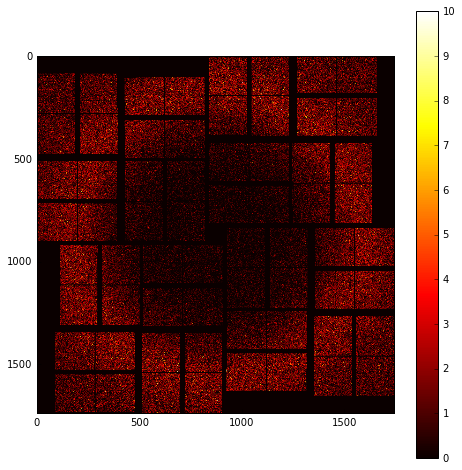

In [179]:
plt.figure(figsize=[8,8])
plt.imshow(ss*mm,aspect=1,
          cmap='hot',vmin=0,vmax=10)
plt.colorbar()

In [117]:
np.where(mm<mask)

(array([ 140,  189,  213,  271,  396,  555,  846, 1000, 1024, 1147, 1154,
        1459, 1495, 1531]),
 array([ 734, 1078,  609, 1156,  357,  297, 1549,  272,  117,  935, 1562,
         563, 1160, 1121]))

In [118]:
cali10_diff= diff_all_shots(cali_shots10,mask, 10)
raw_diff= diff_all_shots(single_shots,mask, 10)

In [119]:
cali_mean_diff = cali10_diff.mean(0)
raw_mean_diff = raw_diff.mean(0)

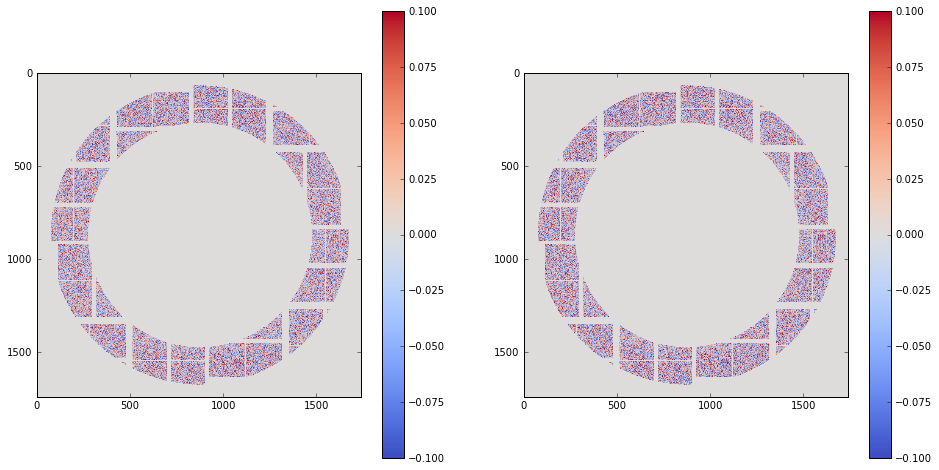

In [272]:
x = -0.1
y=0.1

# img=range_mask(mean_single_shot,x,y)
img = donut_mask(mask,600,800)
plt.figure(figsize=[16,8])
gs = GridSpec(1,2)
threshold = 24
plt.subplot(gs[0,0] )
plt.imshow(raw_mean_diff*img,aspect=1,
          cmap='coolwarm',vmin=x,vmax=y)
plt.colorbar()


plt.subplot(gs[0,1])
plt.imshow(cali_mean_diff*img,aspect=1,
          cmap='coolwarm',vmin=x,vmax=y)
plt.colorbar()

In [121]:
norm_cali_shots = np.zeros_like(cali_shots10,dtype=np.float64)
norm_shots = np.zeros_like(single_shots,dtype=np.float64)
for ii in range(norm_cali_shots.shape[0]):
    ss,mm = norm_w_mask(cali_shots10[ii],mask, threshold=10)
    norm_cali_shots[ii] = ss*mm
    
    ss,mm = norm_w_mask(single_shots[ii],mask, threshold = 10)
    norm_shots[ii] = ss*mm

In [122]:
mean_norm_shots = norm_shots.mean(0)
mean_norm_cali = norm_cali_shots.mean(0)

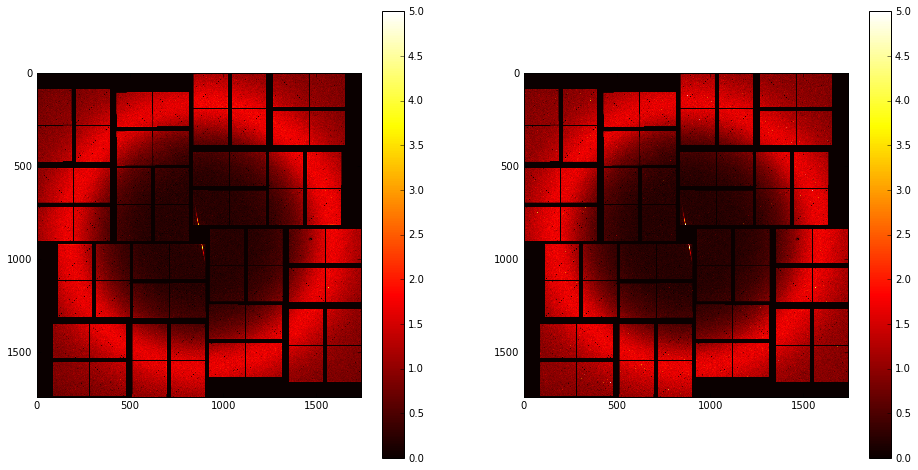

In [123]:
x = 0
y= 5
plt.figure(figsize=[16,8])
gs = GridSpec(1,2)
threshold = 24
plt.subplot(gs[0,0] )
plt.imshow(mean_norm_shots,aspect=1,
          cmap='hot',vmin=x,vmax=y)
plt.colorbar()


plt.subplot(gs[0,1])
plt.imshow(mean_norm_cali,aspect=1,
          cmap='hot',vmin=x,vmax=y)
plt.colorbar()

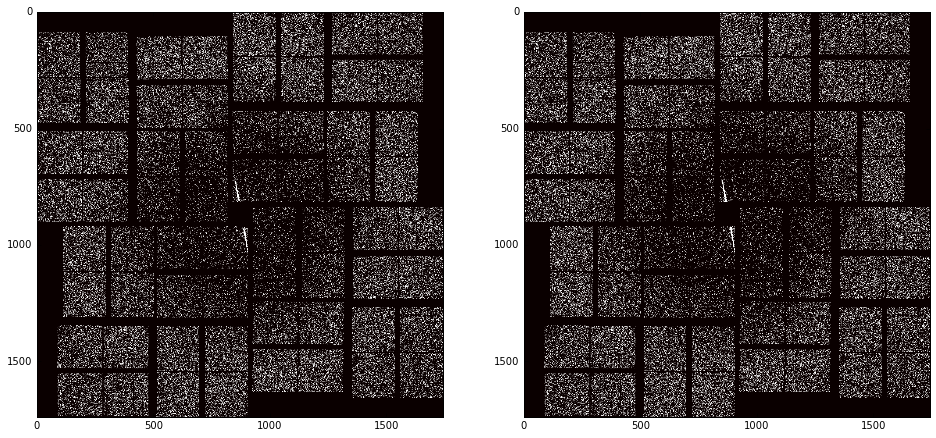

In [133]:
# difference in normalized shots with the sample mean is more isotropic when calibrated
threshold=0.04

plt.figure(figsize=[16,8])
gs = GridSpec(1,2)

plt.subplot(gs[0,0] )
plt.imshow(raw_mean_diff>threshold,aspect=1,
          cmap='hot')
# plt.colorbar()


plt.subplot(gs[0,1])
plt.imshow(cali_mean_diff>threshold,aspect=1,
          cmap='hot')
# plt.colorbar()

In [140]:
bins=np.linspace(-0.5,0.5,100)
hist=np.histogram(raw_mean_diff.flatten(),bins=bins)
hist2=np.histogram(cali_mean_diff.flatten(),bins=bins)

(-0.2, 0.2)

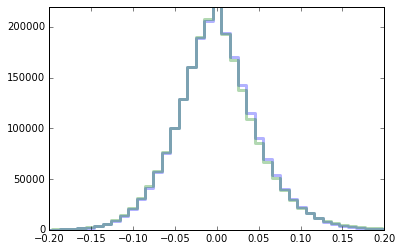

In [151]:
plt.step(bins[1:],hist[0],linestyle='-', linewidth=3, alpha=0.3)
plt.step(bins[1:],hist2[0],linestyle='-', linewidth=3, alpha=0.3)
plt.ylim(0,220000)
plt.xlim(-0.2,0.2)
# hist[0].shape
# bins.shape

(500, 1200)

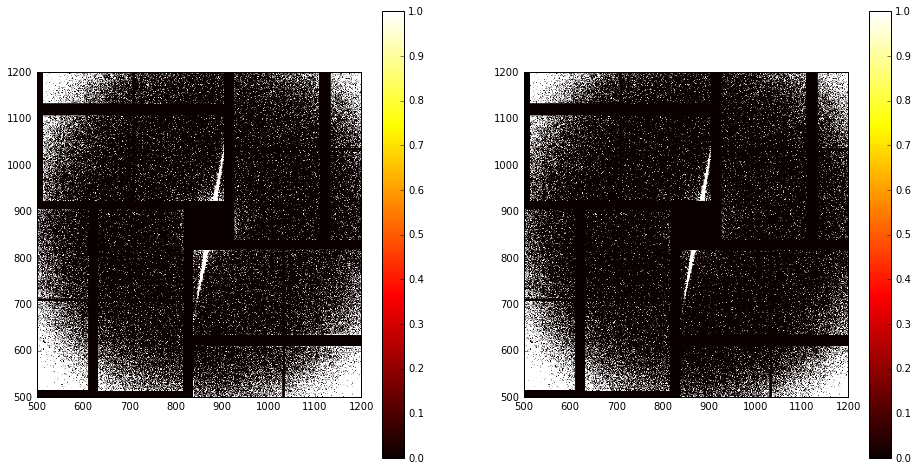

In [131]:

y= 0.34
plt.figure(figsize=[16,8])
gs = GridSpec(1,2)
threshold = 24
plt.subplot(gs[0,0] )
plt.imshow(mean_norm_shots>y,aspect=1,
          cmap='hot')
plt.colorbar()
plt.xlim(500,1200)
plt.ylim(500,1200)


plt.subplot(gs[0,1])
plt.imshow(mean_norm_cali>y,aspect=1,
          cmap='hot')
plt.colorbar()
plt.xlim(500,1200)
plt.ylim(500,1200)

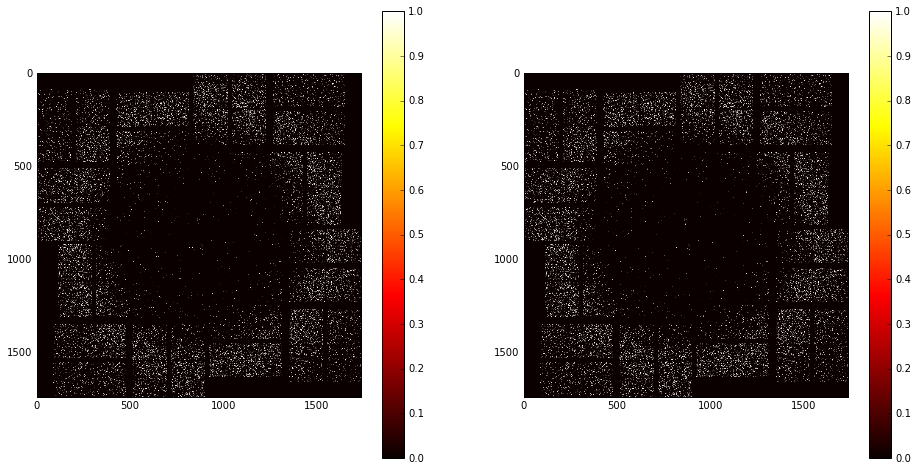

In [132]:
idx=176
y= 4
plt.figure(figsize=[16,8])
gs = GridSpec(1,2)
threshold = 24
plt.subplot(gs[0,0] )
plt.imshow(norm_shots[idx]>y,aspect=1,
          cmap='hot')
plt.colorbar()
# plt.xlim(500,1200)
# plt.ylim(500,1200)


plt.subplot(gs[0,1])
plt.imshow(norm_cali_shots[idx]>y,aspect=1,
          cmap='hot')
plt.colorbar()
# plt.xlim(500,1200)
# plt.ylim(500,1200)

In [86]:
single_shots_int.argmax()

176

In [2]:
import h5py
f_coefs=h5py.File('/reg/d/psdm/cxi/cxilr6716/results/flatfield_calibration/copper_cali_coefs.h5','r')
f_coefs.keys()

[u'cali_fit_nShots',
 u'cali_fit_shots',
 u'coefs_10',
 u'coefs_15',
 u'coefs_20',
 u'coefs_5',
 u'test1_cali_10',
 u'test1_cali_15',
 u'test1_cali_20',
 u'test1_cali_5',
 u'test1_shots',
 u'test2_cali_10',
 u'test2_cali_15',
 u'test2_cali_20',
 u'test2_cali_5']